# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 11

## Additional Setup

The repository for the `allennlp` library has been archived. The library was used by `flair` to provide ELMO embeddings. This required PyTorch to be downgraded to version 1.7.1, and it prevented updating other libraries used in this chapter.

At this point, the sensible solution is to upgrade `flair` and the other packages to more up-to-date versions and retire the use of ELMO embeddings. For the sake of completion, these embeddings will be replaced by flair embeddings in the code. Some code will be commented out whenever the replacement produces results that are substantially different from those produced by ELMO.

Moreover, upgrading the `gensim` library required a few changes in the code since some attributes were changed from its 3.8.3 to its 4.3.3 version. These changes are highlighted in the code.

**IMPORTANT**: due to the major version upgrade, the output of several cells will be quite different than those shown in the book. The new Gensim version produces slightly different vocabularies, so you should expect small changes in the number of words in the vocabulary, for example.

In [1]:
# UPDATED
###########################################################
!pip install gensim==4.3.3
# The library has been archived and won't be used anymore
!pip install allennlp==0.9.0
!pip install flair==0.13.1
!pip install torchvision==0.18.1
# # HuggingFace
!pip install transformers==4.42.4
!pip install datasets==2.18.0
###########################################################

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 1.4 MB/s eta 0:00:00a 0:00:01
  Using cached https://mirrors.aliyun.com/pypi/packages/2c/ab/fc8290c6a4c722e5514d80f62b2dc4c4df1a68a41d1364e625c35990fcf3/overrides-7.7.0-py3-none-any.whl (17 kB)
  Using cached https://mirrors.aliyun.com/pypi/packages/1f/e2/46650d03c7ff2b57ed7af211d41c3f606540f7adea92b5af65fcf9f605c0/spacy-2.1.9.tar.gz (30.7 MB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [40 lines of output]
      Looking in indexes: https://mirrors.aliyun.com/pypi/simple
           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.3 MB ? eta -:--:--
           ━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/1.3 MB ? eta -:--:--
           ━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 0.5/1.

In [2]:
# try:
#     import google.colab
#     import requests
#     url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
#     r = requests.get(url, allow_redirects=True)
#     open('config.py', 'wb').write(r.content)
# except ModuleNotFoundError:
#     pass

from config import *
config_chapter11()
# This is needed to render the plots in this chapter
from plots.chapter11 import *

In [3]:
import os
import json
import errno
import requests
import numpy as np
from copy import deepcopy
from operator import itemgetter

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

from data_generation.nlp import ALICE_URL, WIZARD_URL, download_text
from stepbystep.v4 import StepByStep
# These are the classes we built in Chapter 10
from seq2seq import *

import nltk
from nltk.tokenize import sent_tokenize

In [4]:
import gensim
from gensim import corpora, downloader
from gensim.parsing.preprocessing import *
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

In [5]:
from flair.data import Sentence
#from flair.embeddings import ELMoEmbeddings, WordEmbeddings, \
#    TransformerWordEmbeddings, TransformerDocumentEmbeddings
from flair.embeddings import WordEmbeddings, \
    TransformerWordEmbeddings, TransformerDocumentEmbeddings

/Users/eassi/miniconda3/envs/pysbs/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from datasets import load_dataset, Split
from transformers import (
    DataCollatorForLanguageModeling,
    BertModel, BertTokenizer, BertForSequenceClassification,
    DistilBertModel, DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AutoModelForSequenceClassification,
    AutoModel, AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments, pipeline, TextClassificationPipeline
)
from transformers.pipelines import SUPPORTED_TASKS

# 1. Down the Yellow Brick Rabbit Hole

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/alice_dorothy.png?raw=1)

*Left: "Alice and the Baby Pig" illustration by John Tenniel's, from "Alice's Adventure's in Wonderland" (1865).*

*Right: "Dorothy meets the Cowardly Lion" illustration by W.W. Denslow, from "The Wonderful Wizard of Oz" (1900)*

# 2. Building a Dataset

In [7]:
!ls ./ | grep texts

texts


In [8]:
localfolder = 'texts'
download_text(ALICE_URL, localfolder)
download_text(WIZARD_URL, localfolder)

In [9]:
!ls ./ | grep texts

texts


In [10]:
with open(os.path.join(localfolder, 'alice28-1476.txt'), 'r') as f:
    alice = ''.join(f.readlines()[104:3704])

with open(os.path.join(localfolder, 'wizoz10-1740.txt'), 'r') as f:
    wizard = ''.join(f.readlines()[310:5100])

In [11]:
print(alice[:500])
print('\n')
print(wizard[:500])

                ALICE'S ADVENTURES IN WONDERLAND

                          Lewis Carroll

               THE MILLENNIUM FULCRUM EDITION 2.8




                            CHAPTER I

                      Down the Rabbit-Hole


  Alice was beginning to get very tired of sitting by her sister
on the bank, and of having nothing to do:  once or twice she had
peeped into the book her sister was reading, but it had no
pictures or conversations in it, `and what is the use of a book,'
thought Alice `w


                    THE WONDERFUL WIZARD OF OZ


                          1.  The Cyclone


    Dorothy lived in the midst of the great Kansas prairies, with
Uncle Henry, who was a farmer, and Aunt Em, who was the farmer's
wife.  Their house was small, for the lumber to build it had to be
carried by wagon many miles.  There were four walls, a floor and a
roof, which made one room; and this room contained a rusty looking
cookstove, a cupboard for the dishes, a table, three or four
chairs, and

In [12]:
text_cfg = """fname,start,end
alice28-1476.txt,104,3704
wizoz10-1740.txt,310,5100"""
bytes_written = open(os.path.join(localfolder, 'lines.cfg'), 'w').write(text_cfg)

## 2.1 Sentence Tokenization

将句子分割为单词列表：

In [13]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(' ')
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

In [14]:
from nltk.tokenize import sent_tokenize
import nltk

nltk.download('punkt_tab')
doc = "Hello world! How are you? I'm fine."
sents = sent_tokenize(doc)
sents

[nltk_data] Downloading package punkt_tab to /Users/eassi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['Hello world!', 'How are you?', "I'm fine."]

In [15]:

# nltk.download('punkt')
corpus_alice = sent_tokenize(alice)
corpus_wizard = sent_tokenize(wizard)
len(corpus_alice), len(corpus_wizard)

(1612, 2240)

In [16]:
corpus_alice[2]

'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!'

In [17]:
corpus_wizard[30]

'"There\'s a cyclone coming, Em," he called to his wife.'

清理换行符、使用转义字符包裹特殊字符：

In [18]:
def sentence_tokenize(source, quote_char='\\', sep_char=',',
                      include_header=True, include_source=True,
                      extensions=('txt'), **kwargs):
    nltk.download('punkt')
    # If source is a folder, goes through all files inside it
    # that match the desired extensions ('txt' by default)
    if os.path.isdir(source):
        filenames = [f for f in os.listdir(source)
                     if os.path.isfile(os.path.join(source, f)) and
                        os.path.splitext(f)[1][1:] in extensions]
    elif isinstance(source, str):
        filenames = [source]

    # If there is a configuration file, builds a dictionary with
    # the corresponding start and end lines of each text file
    config_file = os.path.join(source, 'lines.cfg')
    config = {}
    if os.path.exists(config_file):
        with open(config_file, 'r') as f:
            rows = f.readlines()

        for r in rows[1:]:
            fname, start, end = r.strip().split(',')
            config.update({fname: (int(start), int(end))})

    new_fnames = []
    # For each file of text
    for fname in filenames:
        # If there's a start and end line for that file, use it
        try:
            start, end = config[fname]
        except KeyError:
            start = None
            end = None

        # Opens the file, slices the configures lines (if any)
        # cleans line breaks and uses the sentence tokenizer
        with open(os.path.join(source, fname), 'r') as f:
            contents = (''.join(f.readlines()[slice(start, end, None)])
                        .replace('\n', ' ').replace('\r', ''))
        corpus = sent_tokenize(contents, **kwargs)

        # Builds a CSV file containing tokenized sentences
        base = os.path.splitext(fname)[0]
        new_fname = f'{base}.sent.csv'
        new_fname = os.path.join(source, new_fname)
        with open(new_fname, 'w') as f:
            # Header of the file
            if include_header:
                if include_source:
                    f.write('sentence,source\n')
                else:
                    f.write('sentence\n')
            # Writes one line for each sentence
            for sentence in corpus:
                if include_source:
                    f.write(f'{quote_char}{sentence}{quote_char}{sep_char}{fname}\n')
                else:
                    f.write(f'{quote_char}{sentence}{quote_char}\n')
        new_fnames.append(new_fname)

    # Returns list of the newly generated CSV files
    return sorted(new_fnames)

In [19]:
new_fnames = sentence_tokenize(localfolder)
new_fnames

[nltk_data] Downloading package punkt to /Users/eassi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['texts/alice28-1476.sent.csv', 'texts/wizoz10-1740.sent.csv']

也可以使用SpaCy的分句器来替代NLTK的：

In [20]:
import spacy
nlp = spacy.blank("en")
# nlp.add_pipe(nlp.create_pipe("sentencizer"))  # ValueError Found in Spacy==3.7.5
nlp.add_pipe("sentencizer")

sentences = []
for doc in nlp.pipe(corpus_alice):
    sentences.extend(sent.text for sent in doc.sents)

len(sentences), sentences[2]

(1615,
 'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!')

## 2.2 HuggingFace's Dataset

### 2.2.1 Loading a Dataset

In [21]:
from datasets import load_dataset, Split

dataset = load_dataset(path='csv', data_files=new_fnames, quotechar='\\', split=Split.TRAIN)

Generating train split: 3852 examples [00:00, 137423.42 examples/s]


`datasets.load_dataset`函数的`path`参数并不是数据集的路径，而是处理数据集的脚本文件的路径，`data_files`参数才是指定数据集的路径，而`split`就是数据集的划分：训练集、验证集以及测试集（split.TRAIN, split.VALIDATION, split.TEST）。

### 2.2.2 Attributes

In [22]:
dataset.features, dataset.num_columns, dataset.shape

({'sentence': Value(dtype='string', id=None),
  'source': Value(dtype='string', id=None)},
 2,
 (3852, 2))

In [23]:
dataset[3851]

{'sentence': 'I\'m so glad to be at home again!"',
 'source': 'wizoz10-1740.txt'}

In [24]:
dataset['source'][:3]

['alice28-1476.txt', 'alice28-1476.txt', 'alice28-1476.txt']

### 2.2.3 Methods

In [25]:
dataset.unique('source')  # 数据集中source字段的唯一值集合

['alice28-1476.txt', 'wizoz10-1740.txt']

In [26]:
def is_alice_label(row):
    is_alice = int(row['source'] == 'alice28-1476.txt')
    return {'labels': is_alice}  # 在原始的数据集上添加新列：label

dataset = dataset.map(is_alice_label)
dataset

Map: 100%|██████████| 3852/3852 [00:00<00:00, 43556.86 examples/s]


Dataset({
    features: ['sentence', 'source', 'labels'],
    num_rows: 3852
})

In [27]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt',
 'labels': 1}

In [28]:
shuffled_dataset = dataset.shuffle(seed=42)

In [29]:
split_dataset = shuffled_dataset.train_test_split(test_size=0.2)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'source', 'labels'],
        num_rows: 3081
    })
    test: Dataset({
        features: ['sentence', 'source', 'labels'],
        num_rows: 771
    })
})

In [30]:
train_dataset, test_dataset = split_dataset['train'], split_dataset['test']

### 2.2.4 Data Augmentation

In [31]:
# # !pip install textattack
# from textattack.augmentation import EmbeddingAugmenter
# augmenter = EmbeddingAugmenter()
# feynman = 'What I cannot create, I do not understand.'

In [32]:
# for i in range(5):
#     print(augmenter.augment(feynman))

# 3. Word Tokenization

In [33]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(' ')
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

In [34]:
from gensim.parsing.preprocessing import *

preprocess_string(sentence)

['follow', 'white', 'rabbit']

In [35]:
filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric]
preprocess_string(sentence, filters=filters)

['i', 'm', 'following', 'the', 'white', 'rabbit']

In [36]:
from gensim.utils import simple_preprocess

tokens = simple_preprocess(sentence)
tokens

['following', 'the', 'white', 'rabbit']

## 3.1 Vocabulary

In [37]:
sentences = train_dataset['sentence']
tokens = [simple_preprocess(sent) for sent in sentences]
tokens[0]

['you',
 'do',
 'it',
 'that',
 'won',
 'then',
 'bill',
 'to',
 'go',
 'down',
 'here',
 'bill']

In [38]:
len(sentences), len(tokens)

(3081, 3081)

In [39]:
from gensim import corpora

dictionary = corpora.Dictionary(tokens)
print(dictionary)

Dictionary<3705 unique tokens: ['bill', 'do', 'down', 'go', 'here']...>


In [40]:
dictionary.num_docs  # 处理了多少篇文档（这里的文档其实就是句子）

3081

In [41]:
dictionary.num_pos # 处理了多少个token

50832

In [42]:
dictionary.token2id

{'bill': 0,
 'do': 1,
 'down': 2,
 'go': 3,
 'here': 4,
 'it': 5,
 'that': 6,
 'then': 7,
 'to': 8,
 'won': 9,
 'you': 10,
 'and': 11,
 'bread': 12,
 'butter': 13,
 'dropped': 14,
 'hatter': 15,
 'his': 16,
 'knee': 17,
 'miserable': 18,
 'on': 19,
 'one': 20,
 'teacup': 21,
 'the': 22,
 'went': 23,
 'alice': 24,
 'herself': 25,
 'said': 26,
 'did': 27,
 'mouse': 28,
 'thought': 29,
 'don': 30,
 'dorothy': 31,
 'joker': 32,
 'mind': 33,
 'mr': 34,
 'princess': 35,
 'cheered': 36,
 'guinea': 37,
 'other': 38,
 'pig': 39,
 'suppressed': 40,
 'was': 41,
 'but': 42,
 'doubtless': 43,
 'little': 44,
 'much': 45,
 'older': 46,
 'woman': 47,
 'all': 48,
 'answered': 49,
 'as': 50,
 'asked': 51,
 'before': 52,
 'fancy': 53,
 'got': 54,
 'gryphon': 55,
 'hasn': 56,
 'he': 57,
 'in': 58,
 'know': 59,
 'nearly': 60,
 'no': 61,
 'same': 62,
 'she': 63,
 'sorrow': 64,
 'very': 65,
 'words': 66,
 'how': 67,
 'manage': 68,
 'planning': 69,
 'would': 70,
 'again': 71,
 'began': 72,
 'presently': 73,
 

In [43]:
vocab = list(dictionary.token2id.keys())
vocab[:5]

['bill', 'do', 'down', 'go', 'here']

In [44]:
dictionary.cfs  # 收集频率，表示词元在语料库中出现了多少次

{10: 724,
 1: 179,
 5: 822,
 6: 566,
 9: 30,
 7: 169,
 0: 17,
 8: 1483,
 3: 102,
 2: 154,
 4: 75,
 22: 3675,
 18: 2,
 15: 48,
 14: 7,
 16: 235,
 21: 2,
 11: 2000,
 12: 13,
 13: 7,
 23: 101,
 19: 275,
 20: 174,
 17: 6,
 26: 640,
 24: 328,
 25: 84,
 29: 101,
 27: 124,
 28: 40,
 30: 79,
 33: 26,
 34: 2,
 32: 2,
 35: 11,
 31: 289,
 38: 62,
 37: 4,
 39: 7,
 36: 2,
 41: 679,
 40: 3,
 42: 385,
 44: 216,
 47: 32,
 43: 1,
 45: 77,
 46: 3,
 63: 768,
 51: 102,
 55: 46,
 49: 67,
 65: 190,
 60: 22,
 58: 663,
 62: 39,
 66: 24,
 50: 483,
 52: 89,
 48: 338,
 53: 8,
 57: 473,
 56: 2,
 54: 48,
 61: 160,
 64: 3,
 59: 125,
 69: 1,
 67: 107,
 70: 161,
 68: 8,
 73: 3,
 72: 69,
 71: 136,
 80: 183,
 92: 152,
 81: 11,
 77: 391,
 85: 210,
 91: 60,
 94: 107,
 86: 1071,
 90: 22,
 75: 2,
 89: 90,
 79: 137,
 84: 46,
 76: 47,
 88: 49,
 78: 102,
 74: 244,
 93: 1,
 83: 62,
 82: 27,
 87: 121,
 99: 78,
 96: 360,
 97: 77,
 102: 101,
 100: 1,
 95: 1,
 98: 97,
 101: 24,
 106: 32,
 108: 364,
 107: 2,
 104: 108,
 105: 46,
 1

In [45]:
dictionary.dfs  # 文档频率，表示词元出现在多少个不同的文件中

{10: 546,
 1: 176,
 5: 611,
 6: 505,
 9: 24,
 7: 161,
 0: 15,
 8: 1082,
 3: 100,
 2: 140,
 4: 74,
 22: 1881,
 18: 2,
 15: 48,
 14: 7,
 16: 197,
 21: 2,
 11: 1298,
 12: 13,
 13: 7,
 23: 99,
 19: 260,
 20: 164,
 17: 6,
 26: 633,
 24: 319,
 25: 76,
 29: 101,
 27: 120,
 28: 34,
 30: 75,
 33: 26,
 34: 2,
 32: 2,
 35: 11,
 31: 284,
 38: 59,
 37: 4,
 39: 7,
 36: 2,
 41: 541,
 40: 3,
 42: 372,
 44: 202,
 47: 32,
 43: 1,
 45: 77,
 46: 3,
 63: 518,
 51: 102,
 55: 45,
 49: 67,
 65: 177,
 60: 22,
 58: 577,
 62: 39,
 66: 24,
 50: 344,
 52: 88,
 48: 313,
 53: 8,
 57: 366,
 56: 2,
 54: 47,
 61: 152,
 64: 3,
 59: 119,
 69: 1,
 67: 99,
 70: 145,
 68: 8,
 73: 3,
 72: 68,
 71: 131,
 80: 178,
 92: 130,
 81: 11,
 77: 358,
 85: 188,
 91: 58,
 94: 107,
 86: 808,
 90: 20,
 75: 2,
 89: 87,
 79: 134,
 84: 45,
 76: 44,
 88: 45,
 78: 96,
 74: 225,
 93: 1,
 83: 61,
 82: 27,
 87: 120,
 99: 76,
 96: 316,
 97: 77,
 102: 95,
 100: 1,
 95: 1,
 98: 88,
 101: 24,
 106: 31,
 108: 323,
 107: 2,
 104: 107,
 105: 45,
 103: 5

In [46]:
sentence = 'follow the white rabbit'
new_tokens = simple_preprocess(sentence)
ids = dictionary.doc2idx(new_tokens)
print(new_tokens)
print(ids)

['follow', 'the', 'white', 'rabbit']
[553, 22, 696, 578]


In [47]:
special_tokens = {'[PAD]': 0, '[UNK]': 1}
dictionary.patch_with_special_tokens(special_tokens)

In [48]:
def get_rare_ids(dictionary, min_freq):
    """ 删除文档频率少于min_freq的词元 """
    rare_ids = [t[0] for t in dictionary.cfs.items() if t[1] < min_freq]
    return rare_ids

In [49]:
def make_vocab(sentences, folder=None, special_tokens=None, vocab_size=None, min_freq=None):
    if folder is not None:
        if not os.path.exists(folder):
            os.mkdir(folder)

    # tokenizes the sentences and create a Dictionary
    tokens = [simple_preprocess(sent) for sent in sentences]
    dictionary = corpora.Dictionary(tokens)
    # keeps only the most frequent words (vocab size)
    if vocab_size is not None:
        dictionary.filter_extremes(keep_n=vocab_size)  # 只保留vocab_size个词元
    # removes rare words (in case the vocab size still includes words with low frequency)
    if min_freq is not None:
        rare_tokens = get_rare_ids(dictionary, min_freq)
        dictionary.filter_tokens(bad_ids=rare_tokens)  # 删除罕见词元列表中的词元
    # gets the whole list of tokens and frequencies
    items = dictionary.cfs.items()
    # sorts the tokens in descending order
    words = [dictionary[t[0]] for t in sorted(dictionary.cfs.items(), key=lambda t: -t[1])]
    # prepends special tokens, if any
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words

    with open(os.path.join(folder, 'vocab.txt'), 'w') as f:
        for word in words:
            f.write(f'{word}\n')

In [50]:
make_vocab(train_dataset['sentence'], 'our_vocab/', special_tokens=['[PAD]', '[UNK]', '[SEP]', '[CLS]', '[MASK]'], min_freq=2)

In [51]:
!ls our_vocab/

vocab.txt


## 3.2 HugginFace's Tokenizer

In [52]:
from transformers import BertTokenizer

tokenizer = BertTokenizer('our_vocab/vocab.txt')

In [53]:
new_sentence = 'follow the white rabbit neo'
new_tokens = tokenizer.tokenize(new_sentence)
new_tokens

['follow', 'the', 'white', 'rabbit', '[UNK]']

In [54]:
new_ids = tokenizer.convert_tokens_to_ids(new_tokens)
new_ids

[1159, 5, 222, 205, 1]

In [55]:
new_ids = tokenizer.encode(new_sentence)
new_ids

[3, 1159, 5, 222, 205, 1, 2]

In [56]:
tokenizer.convert_ids_to_tokens(new_ids)

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]']

In [57]:
tokenizer.encode(new_sentence, add_special_tokens=False)

[1159, 5, 222, 205, 1]

In [58]:
tokenizer(new_sentence, add_special_tokens=False, return_tensors='pt')

{'input_ids': tensor([[1159,    5,  222,  205,    1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [59]:
sentence1 = 'follow the white rabbit neo'
sentence2 = 'no one can be told what the matrix is'
joined_sentences = tokenizer(sentence1, sentence2)
joined_sentences

{'input_ids': [3, 1159, 5, 222, 205, 1, 2, 53, 49, 71, 34, 290, 43, 5, 1, 29, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [60]:
print(tokenizer.convert_ids_to_tokens(joined_sentences['input_ids']))

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', 'no', 'one', 'can', 'be', 'told', 'what', 'the', '[UNK]', 'is', '[SEP]']


In [61]:
separate_sentences = tokenizer([sentence1, sentence2], padding=True)
separate_sentences

{'input_ids': [[3, 1159, 5, 222, 205, 1, 2, 0, 0, 0, 0], [3, 53, 49, 71, 34, 290, 43, 5, 1, 29, 2]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [62]:
print(tokenizer.convert_ids_to_tokens(separate_sentences['input_ids'][0]))
print(separate_sentences['attention_mask'][0])

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


In [63]:
first_sentences = [sentence1, 'another first sentence']
second_sentences = [sentence2, 'a second sentence here']
batch_of_pairs = tokenizer(first_sentences, second_sentences)
first_input = tokenizer.convert_ids_to_tokens(batch_of_pairs['input_ids'][0])
second_input = tokenizer.convert_ids_to_tokens(batch_of_pairs['input_ids'][1])
print(first_input)
print(second_input)

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', 'no', 'one', 'can', 'be', 'told', 'what', 'the', '[UNK]', 'is', '[SEP]']
['[CLS]', 'another', 'first', 'sentence', '[SEP]', '[UNK]', 'second', 'sentence', 'here', '[SEP]']


In [64]:
tokenized_dataset = tokenizer(dataset['sentence'],
                              padding=True,
                              return_tensors='pt',
                              max_length=50,
                              truncation=True)
tokenized_dataset['input_ids']

tensor([[   3,   27,    1,  ...,   93, 1252,    2],
        [   3,   24,   10,  ..., 1285,    5,    2],
        [   3,   50,   12,  ...,    0,    0,    0],
        ...,
        [   3,    1,    6,  ...,    0,    0,    0],
        [   3,    6,  134,  ...,    0,    0,    0],
        [   3,    1,    1,  ...,    0,    0,    0]])

# 4. Before Word Embeddings

## 4.1 One-Hot Encoding (OHE)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/ohe1.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/ohe2.png?raw=1)

## 4.2 Bag of Words (BoW)

In [65]:
sentence = 'the white rabbit is a rabbit'
bow_tokens = simple_preprocess(sentence)
bow_tokens

['the', 'white', 'rabbit', 'is', 'rabbit']

In [66]:
print(dictionary.doc2idx(bow_tokens))
bow = dictionary.doc2bow(bow_tokens)  # 其实就是一个词频统计表
bow

[22, 696, 578, 187, 578]


[(22, 1), (187, 1), (578, 2), (696, 1)]

## 4.3 Language Models

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/blank1.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/blank2.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/fill1.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/fill2.png?raw=1)

## 4.4 N-grams

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/ngrams.png?raw=1)

## 4.5 Continuous Bag-of-Words (CBoW)
本质上就是使用上下文来预测中心词。

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/blank_end.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/blank_center.png?raw=1)

# 5. Word Embeddings

## 5.1 Word2Vec

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/cbow.png?raw=1)

In [67]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)  # lookup table
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, X):
        embeddings = self.embedding(X)
        bow = embeddings.mean(dim=1)
        logits = self.linear(bow)
        return logits

In [68]:
torch.manual_seed(42)
dummy_cbow = CBOW(vocab_size=5, embedding_size=3)
dummy_cbow.embedding.state_dict()

OrderedDict([('weight',
              tensor([[ 0.3367,  0.1288,  0.2345],
                      [ 0.2303, -1.1229, -0.1863],
                      [ 2.2082, -0.6380,  0.4617],
                      [ 0.2674,  0.5349,  0.8094],
                      [ 1.1103, -1.6898, -0.9890]]))])

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/w2v_embed.png?raw=1)

In [69]:
# tokens: ['is', 'barking']
# lookup tokens' embeddings
dummy_cbow.embedding(torch.as_tensor([2, 3]))

tensor([[ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094]], grad_fn=<EmbeddingBackward0>)

In [70]:
tiny_vocab = ['the', 'small', 'is', 'barking', 'dog']
context_words = ['the', 'small', 'is', 'barking']
target_words = ['dog']

In [71]:
batch_context = torch.as_tensor([[0, 1, 2, 3]]).long()
batch_target = torch.as_tensor([4]).long()

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/w2v_cbow.png?raw=1)

In [72]:
cbow_features = dummy_cbow.embedding(batch_context).mean(dim=1)
cbow_features

tensor([[ 0.7606, -0.2743,  0.3298]], grad_fn=<MeanBackward1>)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/w2v_logits.png?raw=1)

In [73]:
logits = dummy_cbow.linear(cbow_features)
logits

tensor([[ 0.3542,  0.6937, -0.2028, -0.5873,  0.2099]],
       grad_fn=<AddmmBackward0>)

最大的logits对应于”small“，即未经训练的CBOW模型所预测的中心词是”small“而不是”dog“。

## 5.2 What is an Embeddings Anyway?

Embeddings就是单词的特征表示，该表示可以使用相似度来刻画单词之间在语义上的相近性。

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/rest_discrete.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/rest_continuous.png?raw=1)

In [74]:
ratings = torch.as_tensor([[.7, -.4, .7],
                           [.3, .7, -.5],
                           [.9, -.55, .8],
                           [-.3, .8, .34]]).float()
sims = torch.zeros(4, 4)
for i in range(4):
    for j in range(4):
        sims[i, j] = F.cosine_similarity(ratings[i], ratings[j], dim=0)
sims

tensor([[ 1.0000, -0.4318,  0.9976, -0.2974],
        [-0.4318,  1.0000, -0.4270,  0.3581],
        [ 0.9976, -0.4270,  1.0000, -0.3598],
        [-0.2974,  0.3581, -0.3598,  1.0000]])

## 5.3 Pre-trained Word2Vec

我们可以使用`gensim`的`downloader`来选择各种预训练好的词嵌入模型。

## 5.4 Global Vectors (GloVe)

In [75]:
from gensim import downloader

glove = downloader.load('glove-wiki-gigaword-50')

# UPDATED
###########################################################
# The vocab property isn't available anymore at the newer
# Gensim version. It was replaced by key_to_index
# len(glove.vocab)
len(glove.key_to_index)
###########################################################

400000

In [76]:
type(glove)

gensim.models.keyedvectors.KeyedVectors

In [77]:
print(glove["alice"].shape)
glove['alice']

(50,)


array([ 0.16386 ,  0.57795 , -0.59197 , -0.32446 ,  0.29762 ,  0.85151 ,
       -0.76695 , -0.20733 ,  0.21491 , -0.51587 , -0.17517 ,  0.94459 ,
        0.12705 , -0.33031 ,  0.75951 ,  0.44449 ,  0.16553 , -0.19235 ,
        0.065533, -0.12394 ,  0.61446 ,  0.89784 ,  0.17413 ,  0.41149 ,
        1.191   , -0.39461 , -0.459   ,  0.022161, -0.50843 , -0.44464 ,
        0.68721 , -0.7167  ,  0.20835 , -0.23437 ,  0.02604 , -0.47993 ,
        0.31873 , -0.29135 ,  0.50273 , -0.55144 , -0.066692,  0.43873 ,
       -0.24293 , -1.0247  ,  0.029375,  0.068499,  0.25451 , -1.9663  ,
        0.26673 ,  0.88486 ], dtype=float32)

In [78]:
synthetic_queen = glove['king'] - glove['man'] + glove['woman']
synthetic_queen

array([ 0.41736597,  0.90427005, -1.0050299 , -0.06202102,  0.49725997,
        0.80667007, -0.14855   ,  0.80365   , -0.15653998, -0.66973996,
        0.23435399,  0.62476   ,  0.925871  , -0.97099996,  0.92566   ,
        0.89915   , -1.54596   , -0.52625   ,  0.13695401,  0.66199005,
        0.4871601 ,  0.37035   , -0.214214  ,  0.10100996,  0.71358   ,
       -2.0874999 , -1.1362001 , -1.1496099 , -0.53599   ,  0.27389997,
        1.6723    ,  0.02930999, -0.77656007,  0.46056286,  0.34866   ,
       -0.05741701,  0.19444   , -0.207748  , -0.73038995, -0.10751998,
        0.235544  ,  0.96423995, -0.46993998, -0.48727497, -0.25399995,
        0.4621299 , -0.66081   , -1.9451499 , -0.68797004, -0.49784005],
      dtype=float32)

/Users/eassi/ws/py/dl/pytorch_step_by_step/plots/chapter11.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(['', word, ''])


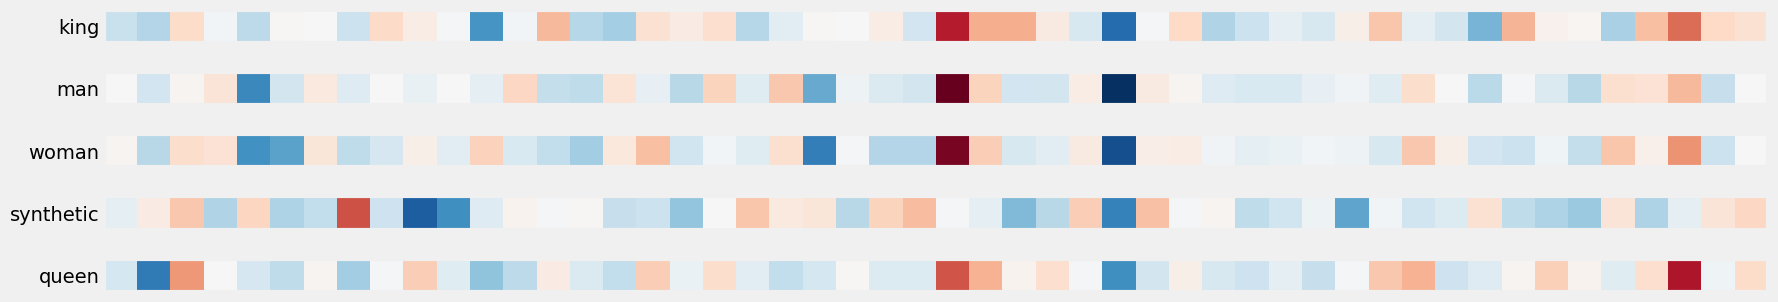

In [79]:
fig = plot_word_vectors(glove,
                        ['king', 'man', 'woman', 'synthetic', 'queen'],
                        other={'synthetic': synthetic_queen})

In [80]:
glove.similar_by_vector(synthetic_queen, topn=5)

[('king', 0.8859835863113403),
 ('queen', 0.8609582185745239),
 ('daughter', 0.7684512138366699),
 ('prince', 0.7640699744224548),
 ('throne', 0.7634971141815186)]

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/embed_arithmetic.png?raw=1)

$$
\Large
w_{\text{king}} - w_{\text{man}}\approx w_{\text{queen}}-w_{\text{woman}} \implies w_{\text{king}} - w_{\text{man}} + w_{\text{woman}} \approx w_{\text{queen}}
$$

## 5.5 Using Word Embeddings

### 5.5.1 Vocabulary Coverage

In [81]:
vocab = list(dictionary.token2id.keys())
len(vocab)

3707

In [82]:
# UPDATED
###########################################################
# The vocab property isn't available anymore at the newer
# Gensim version. It was replaced by key_to_index
# unknown_words = sorted(list(set(vocab).difference(set(glove.vocab))))

unknown_words = sorted(list(set(vocab).difference(set(glove.key_to_index))))
###########################################################
print(len(unknown_words))
print(unknown_words[:5])

43
['[PAD]', '[UNK]', 'arrum', 'barrowful', 'beauti']


In [83]:
unknown_ids = [dictionary.token2id[w] for w in unknown_words if w not in ['[PAD]', '[UNK]']]
unknown_count = np.sum([dictionary.cfs[idx] for idx in unknown_ids])
len(unknown_ids), unknown_count, dictionary.num_pos

(41, 80, 50832)

In [84]:
1 - unknown_count / dictionary.num_pos

0.998426188227888

In [85]:
def vocab_coverage(gensim_dict, pretrained_wv, special_tokens=('[PAD]', '[UNK]')):
    vocab = list(gensim_dict.token2id.keys())
    # UPDATED
    ###########################################################
    # The vocab property isn't available anymore at the newer
    # Gensim version. It was replaced by key_to_index
    # unknown_words = sorted(list(set(vocab).difference(set(pretrained_wv.vocab))))
    unknown_words = sorted(list(set(vocab).difference(set(pretrained_wv.key_to_index))))
    ###########################################################
    unknown_ids = [gensim_dict.token2id[w] for w in unknown_words if w not in special_tokens]
    unknown_count = np.sum([gensim_dict.cfs[idx] for idx in unknown_ids])
    cov = 1 - unknown_count / gensim_dict.num_pos
    return cov

In [86]:
vocab_coverage(dictionary, glove)

0.998426188227888

### 5.5.2 Tokenizer

In [87]:
def make_vocab_from_wv(wv, folder=None, special_tokens=None):
    if folder is not None:
        if not os.path.exists(folder):
            os.mkdir(folder)

    # UPDATED
    ###########################################################
    # The index2word property isn't available anymore at the
    # newer Gensim version. It was replaced by index_to_key
    # words = wv.index2word
    words = wv.index_to_key
    ###########################################################
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words

    with open(os.path.join(folder, 'vocab.txt'), 'w') as f:
        for word in words:
            f.write(f'{word}\n')

In [88]:
make_vocab_from_wv(glove, 'glove_vocab/', special_tokens=['[PAD]', '[UNK]'])

In [89]:
glove_tokenizer = BertTokenizer('glove_vocab/vocab.txt')

In [90]:
glove_tokenizer.encode('alice followed the white rabbit', add_special_tokens=False)

[7101, 930, 2, 300, 12427]

In [91]:
glove_tokenizer.encode('alice followed the white rabbit', add_special_tokens=True)

[400003, 7101, 930, 2, 300, 12427, 400002]

In [92]:
len(glove_tokenizer.vocab), len(glove.vectors)

(400002, 400000)

### 5.5.3 Special Tokens' Embeddings

In [93]:
special_embeddings = np.zeros((2, glove.vector_size))
assert special_embeddings.shape == (2, 50)

In [94]:
# 将特殊词元插入到词嵌入的最前面
extended_embeddings = np.concatenate([special_embeddings, glove.vectors], axis=0)
extended_embeddings.shape

(400002, 50)

In [95]:
alice_idx = glove_tokenizer.encode('alice', add_special_tokens=False)
print(alice_idx)
np.all(extended_embeddings[alice_idx] == glove['alice'])

[7101]


True

In [96]:
for special_token in special_tokens.keys():
    special_idx = glove_tokenizer.encode(special_token, add_special_tokens=False)
    # print(special_token, special_idx)
    print(f"special_token: {special_token}\nspcial_idx: {special_idx}\nspecial_embed: {extended_embeddings[special_idx]}\n")

special_token: [PAD]
spcial_idx: [0]
special_embed: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]

special_token: [UNK]
spcial_idx: [1]
special_embed: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]



## 5.6 Model I - GloVe + Classifier

### 5.6.1 Data Preparation

In [97]:
train_sentences = train_dataset['sentence']
train_labels = train_dataset['labels']

test_sentences = test_dataset['sentence']
test_labels = test_dataset['labels']

In [98]:
train_ids = glove_tokenizer(train_sentences,
                            truncation=True,
                            padding=True,
                            max_length=60,
                            add_special_tokens=False,
                            return_tensors='pt')['input_ids']
train_labels = torch.as_tensor(train_labels).float().view(-1, 1)

test_ids = glove_tokenizer(test_sentences,
                           truncation=True,
                           padding=True,
                           max_length=60,
                           add_special_tokens=False,
                           return_tensors='pt')['input_ids']
test_labels = torch.as_tensor(test_labels).float().view(-1, 1)

In [99]:
train_tensor_dataset = TensorDataset(train_ids, train_labels)
generator = torch.Generator()
train_loader = DataLoader(train_tensor_dataset, batch_size=32, shuffle=True, generator=generator)
test_tensor_dataset = TensorDataset(test_ids, test_labels)
test_loader = DataLoader(test_tensor_dataset, batch_size=32)

### 5.6.2 Pre-Trained PyTorch Embeddings

使用`torch.nn.Embedding.from_pretrained`加载已经过预训练的词嵌入`extended_embeddings`：

In [100]:
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)

In [101]:
token_ids, labels = next(iter(train_loader))
token_ids.shape

torch.Size([32, 60])

In [102]:
token_embeddings = torch_embeddings(token_ids)
token_embeddings.shape

torch.Size([32, 60, 50])

In [103]:
token_embeddings.mean(dim=1)  # 嵌入词袋

tensor([[ 0.0564,  0.0048, -0.0134,  ...,  0.0082,  0.0238,  0.0143],
        [ 0.0195,  0.0257, -0.0911,  ..., -0.3030,  0.0341, -0.1303],
        [ 0.0494,  0.0776, -0.0953,  ..., -0.0713,  0.0222,  0.0213],
        ...,
        [ 0.0312,  0.0173, -0.0271,  ..., -0.0108,  0.0179,  0.0936],
        [ 0.0147,  0.0589, -0.0393,  ..., -0.0742, -0.0071, -0.0109],
        [ 0.0711,  0.1142,  0.0472,  ..., -0.0565,  0.0080,  0.1312]])

In [104]:
boe_mean = nn.EmbeddingBag.from_pretrained(extended_embeddings, mode='mean')
boe_mean(token_ids)

tensor([[ 0.0564,  0.0048, -0.0134,  ...,  0.0082,  0.0238,  0.0143],
        [ 0.0195,  0.0257, -0.0911,  ..., -0.3030,  0.0341, -0.1303],
        [ 0.0494,  0.0776, -0.0953,  ..., -0.0713,  0.0222,  0.0213],
        ...,
        [ 0.0312,  0.0173, -0.0271,  ..., -0.0108,  0.0179,  0.0936],
        [ 0.0147,  0.0589, -0.0393,  ..., -0.0742, -0.0071, -0.0109],
        [ 0.0711,  0.1142,  0.0472,  ..., -0.0565,  0.0080,  0.1312]])

### 5.6.3 Model Configuration & Training

In [105]:
extended_embeddings = torch.as_tensor(extended_embeddings).float()
boe_mean = nn.EmbeddingBag.from_pretrained(
    extended_embeddings, mode='mean'
)
torch.manual_seed(41)
model = nn.Sequential(
    # Embeddings
    boe_mean,
    # Classifier
    nn.Linear(boe_mean.embedding_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [106]:
sbs_emb = StepByStep(model, loss_fn, optimizer)
sbs_emb.set_loaders(train_loader, test_loader)
sbs_emb.train(20)

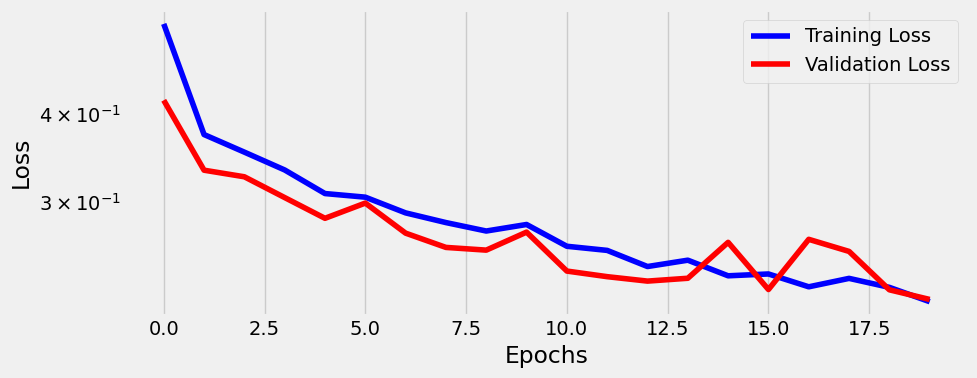

In [107]:
fig = sbs_emb.plot_losses()

In [108]:
StepByStep.loader_apply(test_loader, sbs_emb.correct)

tensor([[434, 461],
        [265, 310]])

In [109]:
acc = (394 + 292) / (436 + 335)
acc

0.8897535667963683

## 5.7 Model II - GloVe + Transformer

In [110]:
class TransfClassifier(nn.Module):
    def __init__(self, embedding_layer, encoder, n_outputs):
        super().__init__()
        self.d_model = encoder.d_model
        self.n_outputs = n_outputs
        self.encoder = encoder
        self.mlp = nn.Linear(self.d_model, n_outputs)

        self.embed = embedding_layer
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.d_model))

    def preprocess(self, X):
        # N, L -> N, L, D
        src = self.embed(X)
        # Special classifier token
        # 1, 1, D -> N, 1, D
        cls_tokens = self.cls_token.expand(X.size(0), -1, -1)
        # Concatenates CLS tokens -> N, 1 + L, D
        src = torch.cat((cls_tokens, src), dim=1)
        return src

    def encode(self, source, source_mask=None):
        # Encoder generates "hidden states"
        states = self.encoder(source, source_mask)
        # Gets state from first token only: [CLS]
        cls_state = states[:, 0]  # N, 1, D
        return cls_state

    @staticmethod
    def source_mask(X):
        cls_mask = torch.ones(X.size(0), 1).type_as(X)
        pad_mask = torch.cat((cls_mask, X > 0), dim=1).bool()
        return pad_mask.unsqueeze(1)

    def forward(self, X):
        src = self.preprocess(X)
        # Featurizer
        cls_state = self.encode(src, self.source_mask(X))
        # Classifier
        out = self.mlp(cls_state) # N, 1, outputs
        return out

In [111]:
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=2, d_model=torch_embeddings.embedding_dim, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1)
# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [112]:
sbs_transf = StepByStep(model, loss_fn, optimizer)
sbs_transf.set_loaders(train_loader, test_loader)
sbs_transf.train(10)

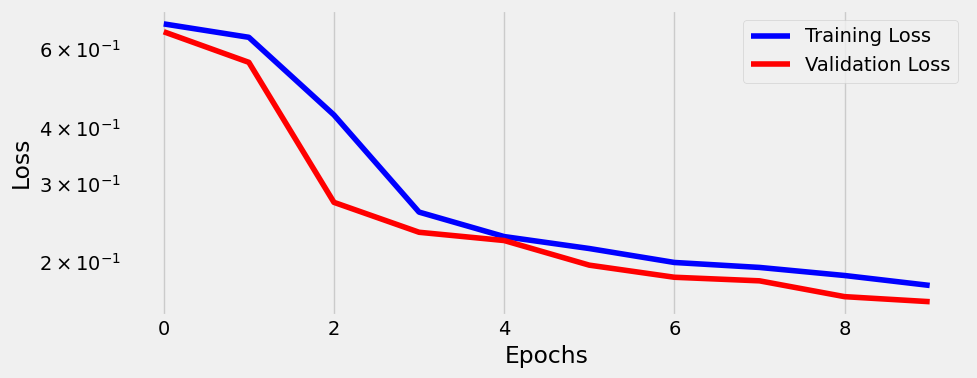

In [113]:
fig = sbs_transf.plot_losses()

In [114]:
result = StepByStep.loader_apply(test_loader, sbs_transf.correct)
result

tensor([[441, 461],
        [273, 310]])

In [115]:
acc = result[:, 0].sum() / result[:, 1].sum()
acc

tensor(0.9261)

### 5.7.1 Visualizing Attention

In [116]:
sentences = ['The white rabbit and Alice ran away', 'The lion met Dorothy on the road']
inputs = glove_tokenizer(sentences, add_special_tokens=False, return_tensors='pt')['input_ids']
inputs = inputs.to(sbs_transf.device)
inputs

tensor([[    2,   300, 12427,     7,  7101,  1423,   422],
        [    2,  6659,   811, 11238,    15,     2,   588]])

In [117]:
sbs_transf.model.eval()
out = sbs_transf.model(inputs)
# our model outputs logits, so we turn them into probs
torch.sigmoid(out)

tensor([[0.9884],
        [0.0096]], grad_fn=<SigmoidBackward0>)

In [118]:
alphas = sbs_transf.model.encoder.layers[0].self_attn_heads.alphas
alphas[:, :, 0, :].squeeze()

tensor([[[3.6876e-01, 6.1594e-02, 1.7166e-01, 1.2706e-01, 8.7007e-02,
          1.1999e-01, 5.2309e-02, 1.1616e-02],
         [2.3023e-05, 2.9113e-03, 4.6448e-03, 9.4574e-02, 3.1957e-03,
          8.9227e-01, 1.0187e-03, 1.3662e-03]],

        [[1.0122e-01, 1.6906e-02, 1.0980e-01, 7.0442e-02, 5.9933e-01,
          8.3238e-03, 1.4901e-02, 7.9073e-02],
         [2.2202e-04, 2.8074e-02, 3.1598e-01, 3.3447e-02, 4.8920e-01,
          6.0277e-02, 3.4975e-02, 3.7821e-02]]])

/Users/eassi/ws/py/dl/pytorch_step_by_step/plots/chapter11.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', f'Head #{i}', ''])


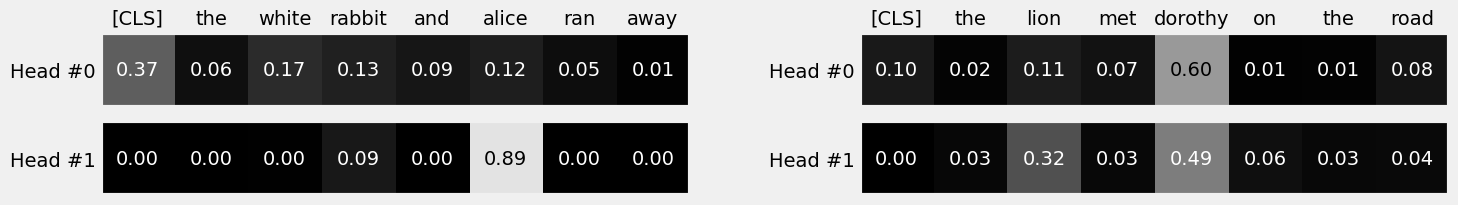

In [119]:
tokens = [['[CLS]'] + glove_tokenizer.tokenize(sent) for sent in sentences]
fig = plot_attention(tokens, alphas)

# 6. Contextual Word Embeddings

## 6.1 ELMo

In [120]:
# 帽匠第一个打破了沉默。“今天几号？”他一边问，一边转向爱丽丝。他从口袋里掏出怀表，不安地看着它，时不时摇晃一下，还把它贴到耳边听一听。
watch1 = """
The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.
"""

# 爱丽丝觉得这非常奇怪，便走近些去观察他们。就在她走到他们跟前时，听到其中一个说道：“小心点，五号！别再像那样把颜料溅到我身上！”
watch2 = """
Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!
"""

sentences = [watch1, watch2]

In [121]:
from flair.data import Sentence

flair_sentences = [Sentence(s) for s in sentences]
print(type(flair_sentences[0]))
print(len(flair_sentences[0]))
print(flair_sentences[0])

<class 'flair.data.Sentence'>
58
Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear."


In [122]:
print(flair_sentences[0].get_token(32))  # 从1开始计数
print(flair_sentences[0].get_token(32).embedding)

Token[31]: "watch"
tensor([])


In [123]:
print(flair_sentences[0].tokens[31])    # 从0开始计数
print(flair_sentences[0].tokens[31].embedding)

Token[31]: "watch"
tensor([])


In [124]:
# !pip install allennlp==0.9.0
# UPDATED
###########################################################
# Unfortunately, ELMO embeddings were returned by flair
# using the allennlp library that has been archived.
# from flair.embeddings import ELMoEmbeddings
# elmo = ELMoEmbeddings()

# As replacement, we'll be using flair's own embeddings instead
from flair.embeddings import FlairEmbeddings
flair_emb = FlairEmbeddings('news-forward')
###########################################################

In [125]:
# UPDATED
###########################################################
# Instead of elmo, embeds sentences using flair embeddings
# elmo.embed(flair_sentences)
flair_emb.embed(flair_sentences)  # 有返回值的
###########################################################

[Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.",
 Sentence[48]: " Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!"]

In [126]:
token_watch1 = flair_sentences[0].tokens[31]
token_watch2 = flair_sentences[1].tokens[13]
token_watch1, token_watch2

(Token[31]: "watch", Token[13]: "watch")

In [127]:
token_watch1.embedding.shape, token_watch2.embedding.shape

(torch.Size([2048]), torch.Size([2048]))

In [128]:
token_watch1.embedding, token_watch2.embedding

(tensor([-0.0007, -0.0057,  0.0187,  ..., -0.0051, -0.0022,  0.0026]),
 tensor([-0.0011, -0.0037,  0.1031,  ..., -0.0079, -0.0044,  0.0002]))

### 6.1.1 Where do ELMo Embeddings come from?

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/elmo_lstm.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/elmo_embed.png?raw=1)

In [129]:
# UPDATED
###########################################################
# Unfortunately, this piece of code only makes sense for
# ELMO embeddings. Flair embeddings are structured differently
# and therefore this code is commented out.
# token_watch1.embedding[0], token_watch1.embedding[512]
###########################################################

In [130]:
# UPDATED
###########################################################
# Unfortunately, this piece of code only makes sense for
# ELMO embeddings. Flair embeddings are structured differently
# and therefore this code is commented out.
# (token_watch1.embedding[:1024] == token_watch2.embedding[:1024]).all()
###########################################################

In [131]:
similarity = nn.CosineSimilarity(dim=0, eps=1e-6)
similarity(token_watch1.embedding, token_watch2.embedding)

tensor(0.5003)

In [132]:
sent1 = Sentence(watch1)
print(sent1.tokens[0].embedding)  # 此时它是空的
flair_emb.embed(sent1)            # 就地操作
print(sent1.tokens[0].embedding)

tensor([])
tensor([-0.0021,  0.0005,  0.0469,  ..., -0.0004, -0.0393,  0.0106])


In [133]:
def get_embeddings(embeddings, sentence):
    sent = Sentence(sentence)
    embeddings.embed(sent)
    return torch.stack([token.embedding for token in sent.tokens]).float()

In [134]:
# UPDATED
###########################################################
# Instead of elmo, embeds sentences using flair embeddings
# get_embeddings(elmo, watch1)
get_embeddings(flair_emb, watch1)
###########################################################

tensor([[-2.0933e-03,  5.0415e-04,  4.6944e-02,  ..., -4.4014e-04,
         -3.9301e-02,  1.0601e-02],
        [ 3.2224e-04,  1.4939e-03,  2.5947e-02,  ..., -9.2416e-04,
         -1.4211e-02,  3.0942e-03],
        [ 1.7407e-03, -1.8324e-04,  5.3374e-02,  ...,  4.5165e-04,
          5.4484e-02,  9.7125e-03],
        ...,
        [ 2.2250e-03,  2.2138e-04,  4.4385e-02,  ..., -3.9766e-03,
         -7.9449e-04,  2.2444e-02],
        [-2.2455e-03,  9.7197e-04,  3.4624e-02,  ..., -7.1559e-05,
          1.2647e-02,  1.3210e-02],
        [ 1.0997e-03,  8.4726e-05,  1.5534e-01,  ..., -1.5737e-04,
          9.5801e-04,  5.3785e-03]])

## 6.2 GloVe in flair

In [135]:
from flair.embeddings import WordEmbeddings
glove_embedding = WordEmbeddings('glove')

In [136]:
print(sentences)
new_flair_sentences = [Sentence(s) for s in sentences]
glove_embedding.embed(new_flair_sentences)

["\nThe Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.\n", "\nAlice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!\n"]


[Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.",
 Sentence[48]: " Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!"]

In [137]:
torch.all(new_flair_sentences[0].tokens[31].embedding == new_flair_sentences[1].tokens[13].embedding)

tensor(True)

使用GloVe，不同上下文中的“watch”具有相同的词嵌入表示。

## 6.3 BERT Embedding

In [138]:
from flair.embeddings import TransformerWordEmbeddings
bert_flair = TransformerWordEmbeddings('bert-base-uncased', layers='-1')

In [139]:
embed1 = get_embeddings(bert_flair, watch1)
embed2 = get_embeddings(bert_flair, watch2)
embed2

tensor([[ 0.6554, -0.3799, -0.2842,  ...,  0.0601,  0.8865,  0.4760],
        [-0.1459, -0.0204, -0.0615,  ..., -0.0257,  0.5052,  0.3324],
        [-0.0436, -0.0400, -0.0135,  ...,  0.3920,  0.5231,  0.9067],
        ...,
        [-0.2582,  0.6933,  0.2688,  ..., -0.0325,  0.0772,  0.2187],
        [-0.1868,  0.6398, -0.8127,  ..., -0.5957,  0.2793,  0.1880],
        [-0.1021,  0.5222, -0.7142,  ...,  0.3644,  0.0600, -0.1419]])

In [140]:
bert_watch1 = embed1[31]
bert_watch2 = embed2[13]
bert_watch1, bert_watch2

(tensor([ 8.5760e-01,  3.5888e-01, -3.7825e-01, -8.3564e-01,  1.3528e+00,
          1.0204e-01, -8.2618e-01,  3.1570e-01,  3.1092e-01, -4.2653e-01,
          1.6632e-01,  7.2440e-02, -1.0276e+00,  4.4680e-01, -1.4549e-01,
          1.8315e-01,  3.7484e-01, -4.0245e-01, -1.4190e-01, -5.1596e-01,
          1.1984e+00,  6.8202e-01,  1.1028e+00, -4.3955e-02,  1.6932e-02,
          7.4420e-01, -1.0604e-01,  3.8719e-01,  7.3663e-02,  2.2424e-01,
         -5.0281e-02,  1.9586e-01,  1.0773e+00,  1.0341e+00,  4.4217e-01,
         -6.5567e-01, -5.6308e-01, -1.1827e-01,  1.2862e-01,  4.6581e-01,
         -7.1305e-01, -1.5682e-01, -1.3552e-01,  4.5853e-02,  8.2848e-03,
          5.2762e-01,  1.6906e+00,  5.5388e-01, -7.3777e-02,  5.1504e-01,
         -2.0619e-01, -2.9496e-03,  2.5389e-01, -1.5379e-01,  8.4900e-01,
          6.5440e-01, -3.2925e-01, -1.1198e+00,  2.4251e-01,  1.5586e-01,
          5.7514e-01,  8.5833e-02,  3.3306e-01, -3.9344e-01, -4.1766e-01,
          1.0790e+00,  1.1719e-02,  7.

In [141]:
similarity = nn.CosineSimilarity(dim=0, eps=1e-6)
similarity(bert_watch1, bert_watch2)

tensor(0.3504)

## 6.4 Document Embeddings

In [142]:
documents = [Sentence(watch1), Sentence(watch2)]

In [143]:
from flair.embeddings import TransformerDocumentEmbeddings
bert_doc = TransformerDocumentEmbeddings('bert-base-uncased')
bert_doc.embed(documents)

[Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.",
 Sentence[48]: " Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!"]

In [144]:
documents[0].embedding

tensor([-6.4244e-02,  3.5365e-01, -2.4962e-01, -5.3912e-01, -1.9917e-01,
        -2.7712e-01,  1.6942e-01,  1.0867e-01, -4.0799e-01, -1.4945e-01,
         4.4678e-02, -1.9687e-01, -3.0574e-01,  9.6215e-02,  2.8053e-01,
         9.0462e-01, -3.0250e-01,  1.7854e-01, -1.6856e-01, -1.7227e-01,
        -1.8270e-01,  4.5121e-01,  3.6128e-01,  1.2309e-01, -1.2046e-02,
        -5.0255e-01,  4.2645e-01, -3.7183e-02, -1.7052e-01, -4.8920e-02,
         1.0503e-01,  3.3456e-01, -3.8482e-02, -4.7287e-01, -7.4432e-02,
         2.3990e-01, -8.3231e-02,  1.7975e-01,  4.8939e-01,  9.3013e-03,
        -4.2722e-01,  2.6338e-01, -1.3217e-01, -1.3950e-01, -1.1859e-01,
         4.5835e-02, -3.9031e+00, -1.0726e-01,  5.1104e-02, -9.9710e-02,
         1.5913e-01, -9.5330e-02,  2.1513e-01,  4.7708e-01,  2.1226e-01,
         4.3450e-01, -4.5154e-01,  1.8344e-01, -1.0171e-01, -3.6373e-01,
         8.9560e-01,  3.5931e-01, -2.8519e-01,  2.9429e-02,  3.3968e-01,
         4.1061e-01, -2.1049e-02,  2.7799e-02,  2.8

In [145]:
documents[0].tokens[31].embedding  # 对整个句子进行嵌入之后，单个词元也就没有嵌入的必要了

tensor([])

In [146]:
def get_embeddings(embeddings, sentence):
    sent = Sentence(sentence)
    embeddings.embed(sent)
    if len(sent.embedding):
        return sent.embedding.float()
    else:
        return torch.stack([token.embedding for token in sent.tokens]).float()

In [147]:
get_embeddings(bert_doc, watch1)

tensor([-6.4244e-02,  3.5365e-01, -2.4962e-01, -5.3912e-01, -1.9917e-01,
        -2.7712e-01,  1.6942e-01,  1.0867e-01, -4.0799e-01, -1.4945e-01,
         4.4678e-02, -1.9687e-01, -3.0574e-01,  9.6215e-02,  2.8053e-01,
         9.0462e-01, -3.0250e-01,  1.7854e-01, -1.6856e-01, -1.7227e-01,
        -1.8270e-01,  4.5121e-01,  3.6128e-01,  1.2309e-01, -1.2046e-02,
        -5.0255e-01,  4.2645e-01, -3.7183e-02, -1.7052e-01, -4.8920e-02,
         1.0503e-01,  3.3456e-01, -3.8482e-02, -4.7287e-01, -7.4432e-02,
         2.3990e-01, -8.3231e-02,  1.7975e-01,  4.8939e-01,  9.3013e-03,
        -4.2722e-01,  2.6338e-01, -1.3217e-01, -1.3950e-01, -1.1859e-01,
         4.5835e-02, -3.9031e+00, -1.0726e-01,  5.1104e-02, -9.9710e-02,
         1.5913e-01, -9.5330e-02,  2.1513e-01,  4.7708e-01,  2.1226e-01,
         4.3450e-01, -4.5154e-01,  1.8344e-01, -1.0171e-01, -3.6373e-01,
         8.9560e-01,  3.5931e-01, -2.8519e-01,  2.9429e-02,  3.3968e-01,
         4.1061e-01, -2.1049e-02,  2.7799e-02,  2.8

## 6.5 Model III - Preprocessing Embeddings

### 6.5.1 Data Preparation

In [148]:
print(train_dataset, "\n")
print(test_dataset)

Dataset({
    features: ['sentence', 'source', 'labels'],
    num_rows: 3081
}) 

Dataset({
    features: ['sentence', 'source', 'labels'],
    num_rows: 771
})


In [149]:
train_dataset_doc = train_dataset.map(lambda row: {'embeddings': get_embeddings(bert_doc, row['sentence'])})
test_dataset_doc = test_dataset.map(lambda row: {'embeddings': get_embeddings(bert_doc, row['sentence'])})

Map: 100%|██████████| 771/771 [00:31<00:00, 24.80 examples/s]


In [150]:
train_dataset_doc.set_format(type='torch', columns=['embeddings', 'labels'])
test_dataset_doc.set_format(type='torch', columns=['embeddings', 'labels'])

In [151]:
train_dataset_doc['embeddings'].shape

torch.Size([3081, 768])

In [152]:
train_dataset_doc = TensorDataset(train_dataset_doc['embeddings'].float(),
                                  train_dataset_doc['labels'].view(-1, 1).float())
generator = torch.Generator()
train_loader = DataLoader(train_dataset_doc, batch_size=32, shuffle=True, generator=generator)

test_dataset_doc = TensorDataset(test_dataset_doc['embeddings'].float(),
                                 test_dataset_doc['labels'].view(-1, 1).float())
test_loader = DataLoader(test_dataset_doc, batch_size=32, shuffle=True)

### 6.5.2 Model Configuration & Training

In [153]:
torch.manual_seed(41)
model = nn.Sequential(
    # Classifier
    nn.Linear(bert_doc.embedding_length, 3),  # 仅需三个隐藏单元
    nn.ReLU(),
    nn.Linear(3, 1)
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [154]:
sbs_doc_emb = StepByStep(model, loss_fn, optimizer)
sbs_doc_emb.set_loaders(train_loader, test_loader)
sbs_doc_emb.train(20)

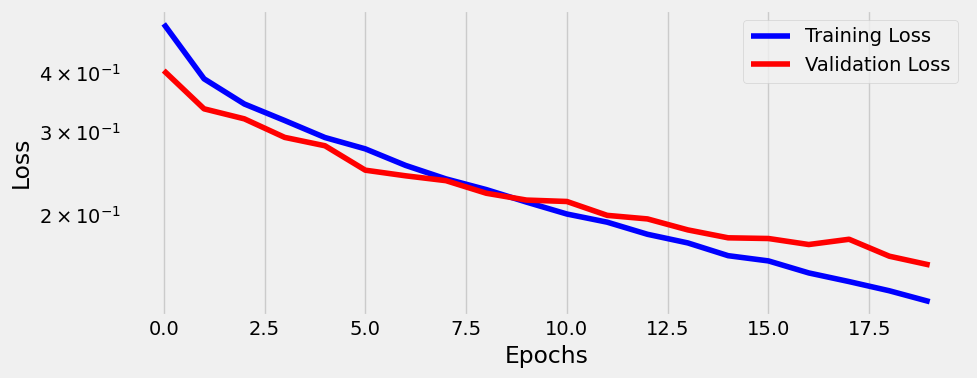

In [155]:
fig = sbs_doc_emb.plot_losses()

In [156]:
result = StepByStep.loader_apply(test_loader, sbs_doc_emb.correct)
result.shape, result

(torch.Size([2, 2]),
 tensor([[448, 461],
         [289, 310]]))

In [157]:
acc = result[:, 0].sum() / result[:, 1].sum()
acc

tensor(0.9559)

# 7. BERT

In [158]:
from transformers import AutoModel
auto_model = AutoModel.from_pretrained('bert-base-uncased')
print(auto_model.__class__)

<class 'transformers.models.bert.modeling_bert.BertModel'>


In [159]:
from transformers import BertModel
bert_model = BertModel.from_pretrained("bert-base-uncased")
print(bert_model.__class__)

<class 'transformers.models.bert.modeling_bert.BertModel'>


In [160]:
bert_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## 7.1 Tokenization

In [161]:
from transformers import BertTokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
len(bert_tokenizer.vocab)

30522

In [162]:
sentence1 = 'Alice is inexplicably following the white rabbit'
sentence2 = 'Follow the white rabbit, Neo'
tokens = bert_tokenizer(sentence1, sentence2, return_tensors='pt')  # tokenize sentence pair
for k in tokens.keys():
    print(f"{k}: {tokens[k]}")

input_ids: tensor([[  101,  5650,  2003,  1999, 10288, 24759,  5555,  6321,  2206,  1996,
          2317, 10442,   102,  3582,  1996,  2317, 10442,  1010,  9253,   102]])
token_type_ids: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [163]:
print(bert_tokenizer.convert_ids_to_tokens(tokens['input_ids'][0]))

['[CLS]', 'alice', 'is', 'in', '##ex', '##pl', '##ica', '##bly', 'following', 'the', 'white', 'rabbit', '[SEP]', 'follow', 'the', 'white', 'rabbit', ',', 'neo', '[SEP]']


In [164]:
from transformers import AutoTokenizer
auto_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
print(auto_tokenizer.__class__)

<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


## 7.2 Input Embeddings

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/bert_input_embed.png?raw=1)

In [165]:
input_embeddings = bert_model.embeddings
input_embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

词嵌入：

In [166]:
token_embeddings = input_embeddings.word_embeddings
token_embeddings

Embedding(30522, 768, padding_idx=0)

In [167]:
input_token_emb = token_embeddings(tokens['input_ids'])
input_token_emb

tensor([[[ 1.3630e-02, -2.6490e-02, -2.3503e-02,  ...,  8.6805e-03,
           7.1340e-03,  1.5147e-02],
         [-6.9710e-02, -8.8202e-02,  5.0619e-03,  ...,  1.4105e-02,
           2.1815e-02, -1.3769e-02],
         [-3.6044e-02, -2.4606e-02, -2.5735e-02,  ...,  3.3691e-03,
          -1.8300e-03,  2.6855e-02],
         ...,
         [ 5.2089e-05, -1.0468e-02, -9.9103e-03,  ...,  1.4558e-02,
           1.3217e-02,  2.2406e-02],
         [-3.5037e-02, -7.2933e-02, -3.6124e-02,  ..., -5.7723e-02,
          -5.5074e-03,  7.2688e-03],
         [-1.4521e-02, -9.9615e-03,  6.0263e-03,  ..., -2.5035e-02,
           4.6379e-03, -1.5378e-03]]], grad_fn=<EmbeddingBackward0>)

位置嵌入：

In [168]:
position_embeddings = input_embeddings.position_embeddings
position_embeddings

Embedding(512, 768)

In [169]:
position_ids = torch.arange(512).expand((1, -1))
position_ids

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 173, 174, 175, 176

In [170]:
seq_length = tokens['input_ids'].size(1)
print(seq_length)
input_pos_emb = position_embeddings(position_ids[:, :seq_length])
input_pos_emb.shape

20


torch.Size([1, 20, 768])

句子对嵌入：

In [171]:
segment_embeddings = input_embeddings.token_type_embeddings
segment_embeddings

Embedding(2, 768)

In [172]:
input_seg_emb = segment_embeddings(tokens['token_type_ids'])
input_seg_emb

tensor([[[ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
         [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
         [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
         ...,
         [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112],
         [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112],
         [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112]]],
       grad_fn=<EmbeddingBackward0>)

In [173]:
input_emb = input_token_emb + input_pos_emb + input_seg_emb
input_emb

tensor([[[ 0.0316, -0.0411, -0.0564,  ...,  0.0021,  0.0044,  0.0219],
         [-0.0615, -0.0750, -0.0107,  ...,  0.0364,  0.0482, -0.0277],
         [-0.0469, -0.0156, -0.0336,  ...,  0.0117,  0.0135,  0.0109],
         ...,
         [-0.0081, -0.0051, -0.0172,  ...,  0.0542, -0.0103,  0.0083],
         [-0.0425, -0.0756, -0.0414,  ..., -0.0252, -0.0180, -0.0060],
         [-0.0138, -0.0138, -0.0194,  ...,  0.0032, -0.0011, -0.0133]]],
       grad_fn=<AddBackward0>)

## 7.3 Pretraining Tasks

### 7.3.1 Masked Language Model (MLM)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/bert_mlm.png?raw=1)

In [174]:
sentence = 'Alice is inexplicably following the white rabbit'
tokens = bert_tokenizer(sentence)
tokens['input_ids']

[101, 5650, 2003, 1999, 10288, 24759, 5555, 6321, 2206, 1996, 2317, 10442, 102]

In [175]:
from transformers import DataCollatorForLanguageModeling
torch.manual_seed(41)
data_collator = DataCollatorForLanguageModeling(tokenizer=bert_tokenizer, mlm_probability=0.15)
mlm_tokens = data_collator([tokens])
for k in mlm_tokens.keys():
    print(f"{k}: {mlm_tokens[k]}")

input_ids: tensor([[  101,  5650,  2003,  1999, 10288, 24759,   103,  6321,  2206,  1996,
          2317, 10442,   102]])
token_type_ids: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
labels: tensor([[-100, -100, -100, -100, -100, -100, 5555, -100, -100, -100, -100, -100,
         -100]])


In [176]:
print(bert_tokenizer.convert_ids_to_tokens(tokens['input_ids']))
print(bert_tokenizer.convert_ids_to_tokens(mlm_tokens['input_ids'][0]))

['[CLS]', 'alice', 'is', 'in', '##ex', '##pl', '##ica', '##bly', 'following', 'the', 'white', 'rabbit', '[SEP]']
['[CLS]', 'alice', 'is', 'in', '##ex', '##pl', '[MASK]', '##bly', 'following', 'the', 'white', 'rabbit', '[SEP]']


### 7.3.2 Next Sentence Prediction (NSP)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/bert_nsp.png?raw=1)

In [177]:
bert_model.pooler

BertPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

In [178]:
sentence1 = 'alice follows the white rabbit'
sentence2 = 'follow the white rabbit neo'
bert_tokenizer(sentence1, sentence2, return_tensors='pt')

{'input_ids': tensor([[  101,  5650,  4076,  1996,  2317, 10442,   102,  3582,  1996,  2317,
         10442,  9253,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

## 7.4 Outputs

In [179]:
sentence = train_dataset[0]['sentence']
sentence

"YOU do it!--That I won't, then!--Bill's to go down--Here, Bill!"

In [180]:
tokens = bert_tokenizer(sentence,
                        padding='max_length',
                        max_length=30,
                        truncation=True,
                        return_tensors="pt")
tokens

{'input_ids': tensor([[ 101, 2017, 2079, 2009,  999, 1011, 1011, 2008, 1045, 2180, 1005, 1056,
         1010, 2059,  999, 1011, 1011, 3021, 1005, 1055, 2000, 2175, 2091, 1011,
         1011, 2182, 1010, 3021,  999,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]])}

In [181]:
bert_model.eval()
out = bert_model(input_ids=tokens['input_ids'],
                 attention_mask=tokens['attention_mask'],
                 output_attentions=True,
                 output_hidden_states=True,
                 return_dict=True)
type(out), out.keys()  # 并没有pooler_output

(transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions,
 odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions']))

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/bert_embeddings.png?raw=1)

In [182]:
last_hidden_batch = out['last_hidden_state']
last_hidden_sentence = last_hidden_batch[0]
print(f"last_hidden_sentence.shape: {last_hidden_sentence.shape}")
# Removes hidden states for [PAD] tokens using the mask
mask = tokens['attention_mask'].squeeze().bool()
print(f"mask: {mask}\n")
embeddings = last_hidden_sentence[mask]
print(f"embeddings shape: {embeddings.shape}")
# Removes embeddings for the first [CLS] and last [SEP] tokens
embeddings[1:-1]

last_hidden_sentence.shape: torch.Size([30, 768])
mask: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True])

embeddings shape: torch.Size([30, 768])


tensor([[ 0.0737, -0.1362,  0.4037,  ...,  0.6090,  1.0660,  0.2533],
        [ 0.3895,  0.3311,  0.5368,  ...,  0.1318,  0.4006, -0.2846],
        [ 0.1331, -0.5897, -0.3821,  ..., -0.1678, -0.1166,  0.2477],
        ...,
        [-0.3396, -0.0417,  0.6300,  ..., -0.6567, -0.7393, -0.1308],
        [ 0.8157, -0.0505,  1.0519,  ...,  0.4265,  0.1710,  0.1161],
        [-0.3367, -0.4388, -0.3289,  ...,  0.5459, -0.2061,  0.0246]],
       grad_fn=<SliceBackward0>)

In [183]:
result = get_embeddings(bert_flair, sentence)
result

tensor([[ 0.0228, -0.0926,  0.3835,  ...,  0.6692,  0.9753,  0.1970],
        [ 0.2330,  0.2368,  0.5566,  ...,  0.4134,  0.6367, -0.2673],
        [-0.0447, -0.5147, -0.3535,  ..., -0.2223, -0.0537,  0.2963],
        ...,
        [-0.2250, -0.0427,  0.6586,  ..., -0.5243, -0.7735, -0.1855],
        [ 0.7631,  0.0102,  1.0591,  ...,  0.4384,  0.1100, -0.0261],
        [-0.2540, -0.3786, -0.3409,  ...,  0.5967, -0.1632, -0.0609]])

In [184]:
print(len(out['hidden_states']))
print(out['hidden_states'][0].shape)

13
torch.Size([1, 30, 768])


In [185]:
(out['hidden_states'][0] == bert_model.embeddings(tokens['input_ids'])).all()

tensor(True)

In [186]:
(out['hidden_states'][-1] == out['last_hidden_state']).all()

tensor(True)

In [187]:
# (out['pooler_output'] == bert_model.pooler(out['last_hidden_state'])).all()

In [188]:
print(len(out['attentions']))
print(out['attentions'][0].shape)

12
torch.Size([1, 12, 30, 30])


## 7.5 Model IV - Classifying using BERT

In [189]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, ff_units, n_outputs, dropout=0.3):
        super().__init__()
        self.d_model = bert_model.config.dim
        self.n_outputs = n_outputs
        self.encoder = bert_model
        self.mlp = nn.Sequential(
            nn.Linear(self.d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, n_outputs)
        )

    def encode(self, source, source_mask=None):
        states = self.encoder(input_ids=source,
                              attention_mask=source_mask)[0]
        cls_state = states[:, 0]
        return cls_state

    def forward(self, X):
        source_mask = (X > 0)
        # Featurizer
        cls_state = self.encode(X, source_mask)
        # Classifier
        out = self.mlp(cls_state)
        return out

### 7.5.1 Data Preparation

In [190]:
def tokenize_dataset(hf_dataset, sentence_field, label_field, tokenizer, **kwargs):
    sentences = hf_dataset[sentence_field]
    token_ids = tokenizer(sentences, return_tensors='pt', **kwargs)['input_ids']
    labels = torch.as_tensor(hf_dataset[label_field])
    dataset = TensorDataset(token_ids, labels)
    return dataset

In [191]:
auto_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer_kwargs = dict(truncation=True, padding=True, max_length=30, add_special_tokens=True)

In [192]:
train_dataset_float = train_dataset.map(lambda row: {'labels': [float(row['labels'])]})
test_dataset_float = test_dataset.map(lambda row: {'labels': [float(row['labels'])]})

train_tensor_dataset = tokenize_dataset(train_dataset_float, 'sentence', 'labels', auto_tokenizer, **tokenizer_kwargs)
test_tensor_dataset = tokenize_dataset(test_dataset_float, 'sentence', 'labels', auto_tokenizer, **tokenizer_kwargs)

generator = torch.Generator()
train_loader = DataLoader(train_tensor_dataset, batch_size=4, shuffle=True, generator=generator)
test_loader = DataLoader(test_tensor_dataset, batch_size=8)

Map: 100%|██████████| 771/771 [00:00<00:00, 23103.75 examples/s]


### 7.5.2 Model Configuration & Training

In [193]:
torch.manual_seed(41)
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")
model = BERTClassifier(bert_model, 128, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [194]:
sbs_bert = StepByStep(model, loss_fn, optimizer)
sbs_bert.set_loaders(train_loader, test_loader)
sbs_bert.train(1)

In [195]:
sbs_bert.count_parameters()

66461441

In [196]:
result = StepByStep.loader_apply(test_loader, sbs_bert.correct)

In [197]:
acc = result[:, 0].sum() / result[:, 1].sum()
acc

tensor(0.9715)

# 8. Fine-Tuning with HuggingFace

## 8.1 Sequence Classification (or Regression)

In [198]:
from transformers import DistilBertForSequenceClassification
torch.manual_seed(42)
bert_cls = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

In [199]:
from transformers import AutoModelForSequenceClassification
auto_cls = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
print(auto_cls.__class__)

<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>


## 8.2 Tokenized Dataset

In [200]:
auto_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize(row):
    return auto_tokenizer(row['sentence'],
                          truncation=True,
                          padding='max_length',
                          max_length=30)

In [201]:
tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, batched=True)

Map: 100%|██████████| 771/771 [00:00<00:00, 11173.91 examples/s]


In [202]:
print(tokenized_train_dataset[0])

{'sentence': "YOU do it!--That I won't, then!--Bill's to go down--Here, Bill!", 'source': 'alice28-1476.txt', 'labels': 1, 'input_ids': [101, 2017, 2079, 2009, 999, 1011, 1011, 2008, 1045, 2180, 1005, 1056, 1010, 2059, 999, 1011, 1011, 3021, 1005, 1055, 2000, 2175, 2091, 1011, 1011, 2182, 1010, 3021, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [203]:
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [204]:
tokenized_train_dataset[0]

{'labels': tensor(1),
 'input_ids': tensor([ 101, 2017, 2079, 2009,  999, 1011, 1011, 2008, 1045, 2180, 1005, 1056,
         1010, 2059,  999, 1011, 1011, 3021, 1005, 1055, 2000, 2175, 2091, 1011,
         1011, 2182, 1010, 3021,  999,  102]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1])}

## 8.3 Trainer

In [205]:
from transformers import Trainer
trainer = Trainer(model=bert_cls, train_dataset=tokenized_train_dataset)

In [206]:
trainer.args

TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=True,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=no,
evaluation_strategy=None,
fp16=False,
fp16_backend=auto,
fp16_

In [207]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='output',
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    evaluation_strategy='steps',
    eval_steps=300,
    logging_steps=300,
    gradient_accumulation_steps=8,
    no_cuda=True
)

/Users/eassi/miniconda3/envs/pysbs/lib/python3.8/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/eassi/miniconda3/envs/pysbs/lib/python3.8/site-packages/transformers/training_args.py:1509: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [208]:
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [209]:
trainer = Trainer(model=bert_cls,
                  args=training_args,
                  train_dataset=tokenized_train_dataset,
                  eval_dataset=tokenized_test_dataset,
                  compute_metrics=compute_metrics)

In [210]:
trainer.train()

{'loss': 0.1929, 'grad_norm': 0.03220600262284279, 'learning_rate': 1.103896103896104e-05, 'epoch': 0.7789678675754625}
{'eval_loss': 0.08541426807641983, 'eval_accuracy': 0.9753566796368353, 'eval_runtime': 5.6237, 'eval_samples_per_second': 137.099, 'eval_steps_per_second': 17.249, 'epoch': 0.7789678675754625}
{'train_runtime': 313.9676, 'train_samples_per_second': 9.813, 'train_steps_per_second': 1.226, 'train_loss': 0.17565309351140804, 'epoch': 0.9996754300551769}


TrainOutput(global_step=385, training_loss=0.17565309351140804, metrics={'train_runtime': 313.9676, 'train_samples_per_second': 9.813, 'train_steps_per_second': 1.226, 'train_loss': 0.17565309351140804, 'epoch': 0.9996754300551769})

In [211]:
trainer.evaluate()

{'eval_loss': 0.08870341628789902, 'eval_accuracy': 0.9779507133592736, 'eval_runtime': 6.1775, 'eval_samples_per_second': 124.807, 'eval_steps_per_second': 15.702, 'epoch': 0.9996754300551769}


{'eval_loss': 0.08870341628789902,
 'eval_accuracy': 0.9779507133592736,
 'eval_runtime': 6.1775,
 'eval_samples_per_second': 124.807,
 'eval_steps_per_second': 15.702,
 'epoch': 0.9996754300551769}

In [212]:
trainer.save_model('bert_alice_vs_wizard')
os.listdir('bert_alice_vs_wizard')

['model.safetensors', 'config.json', 'training_args.bin']

In [213]:
loaded_model = AutoModelForSequenceClassification.from_pretrained('bert_alice_vs_wizard')
loaded_model.device

device(type='cpu')

In [214]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_model.to(device)
loaded_model.device

device(type='cpu')

## 8.4 Predictions

In [215]:
sentence = 'Down the yellow brick rabbit hole'
tokens = auto_tokenizer(sentence, return_tensors='pt')
tokens

{'input_ids': tensor([[  101,  2091,  1996,  3756,  5318, 10442,  4920,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [216]:
print(type(tokens))
tokens.to(loaded_model.device)

<class 'transformers.tokenization_utils_base.BatchEncoding'>


{'input_ids': tensor([[  101,  2091,  1996,  3756,  5318, 10442,  4920,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [217]:
loaded_model.eval()
logits = loaded_model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])
logits

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.6035, -0.6262]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [218]:
logits.logits.argmax(dim=1)

tensor([0])

## 8.5 Pipeline

In [219]:
from transformers import TextClassificationPipeline
device_index = loaded_model.device.index if loaded_model.device.type != 'cpu' else -1
classifier = TextClassificationPipeline(model=loaded_model,
                                        tokenizer=auto_tokenizer,
                                        device=device_index)

In [220]:
classifier(['Down the Yellow Brick Rabbit Hole', 'Alice rules!'])

[{'label': 'LABEL_0', 'score': 0.773758590221405},
 {'label': 'LABEL_1', 'score': 0.9982953667640686}]

In [221]:
loaded_model.config.id2label = {0: 'Wizard', 1: 'Alice'}

In [222]:
classifier(['Down the Yellow Brick Rabbit Hole', 'Alice rules!'])

[{'label': 'Wizard', 'score': 0.773758590221405},
 {'label': 'Alice', 'score': 0.9982953667640686}]

## 8.6 More Pipelines

In [223]:
from transformers import pipeline
sentiment = pipeline('sentiment-analysis')  # 情感分析

In [224]:
sentence = train_dataset[0]['sentence']
print(sentence)
print(sentiment(sentence))

YOU do it!--That I won't, then!--Bill's to go down--Here, Bill!
[{'label': 'POSITIVE', 'score': 0.9982642531394958}]


In [225]:
from transformers.pipelines import SUPPORTED_TASKS
# UPDATED
###########################################################
# sentiment-analysis was replaced by text-classification
# in the dictionary of supported tasks
# SUPPORTED_TASKS['sentiment-analysis']
SUPPORTED_TASKS['text-classification']
###########################################################

{'impl': transformers.pipelines.text_classification.TextClassificationPipeline,
 'tf': (),
 'pt': (transformers.models.auto.modeling_auto.AutoModelForSequenceClassification,),
 'default': {'model': {'pt': ('distilbert/distilbert-base-uncased-finetuned-sst-2-english',
    'af0f99b'),
   'tf': ('distilbert/distilbert-base-uncased-finetuned-sst-2-english',
    'af0f99b')}},
 'type': 'text'}

In [226]:
SUPPORTED_TASKS['text-generation']

{'impl': transformers.pipelines.text_generation.TextGenerationPipeline,
 'tf': (),
 'pt': (transformers.models.auto.modeling_auto.AutoModelForCausalLM,),
 'default': {'model': {'pt': ('openai-community/gpt2', '6c0e608'),
   'tf': ('openai-community/gpt2', '6c0e608')}},
 'type': 'text'}

# 9. GPT-2

In [227]:
text_generator = pipeline("text-generation")

In [228]:
text_generator.model.config.task_specific_params

{'text-generation': {'do_sample': True, 'max_length': 50}}

In [229]:
base_text = """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do:  once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,'thought Alice `without pictures or conversation?' So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
"""

In [230]:
result = text_generator(base_text, max_length=250)
print(result[0]['generated_text'])


Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do:  once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,'thought Alice `without pictures or conversation?' So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.

With a little perseverance Alice managed to make the long walk back to her mother's room and stood by her, taking all the letters from her old mother to her new one too. Not knowing where she was, she was surprised to note her sister's room was too quiet because her uncle's house was already packed in the attic. Her uncle had also told her that it was necessary to hurry up and get home and she was quite

# 10. Putting It All Together

## 10.1 Data Preparation

In [231]:
dataset = load_dataset(path='csv', data_files=['texts/alice28-1476.sent.csv'], quotechar='\\', split=Split.TRAIN)

Generating train split: 1612 examples [00:00, 38110.48 examples/s]


In [232]:
shuffled_dataset = dataset.shuffle(seed=42)
split_dataset = shuffled_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset, test_dataset = split_dataset['train'], split_dataset['test']

In [233]:
auto_tokenizer = AutoTokenizer.from_pretrained('gpt2')
def tokenize(row):
    return auto_tokenizer(row['sentence'])

In [234]:
tokenized_train_dataset = train_dataset.map(tokenize, remove_columns=['source', 'sentence'], batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, remove_columns=['source', 'sentence'], batched=True)

Map: 100%|██████████| 323/323 [00:00<00:00, 15140.88 examples/s]


In [235]:
list(map(len, tokenized_train_dataset[0:6]['input_ids']))

[9, 28, 20, 9, 34, 29]

In [236]:
tokenized_train_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1289
})

### 10.1.1 "Packed" Dataset

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/block_tokens.png?raw=1)

In [237]:
# Adapted from https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_clm.py
def group_texts(examples, block_size=128):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [238]:
lm_train_dataset = tokenized_train_dataset.map(group_texts, batched=True)
lm_test_dataset = tokenized_test_dataset.map(group_texts, batched=True)
lm_train_dataset.set_format(type='torch')
lm_test_dataset.set_format(type='torch')

Map: 100%|██████████| 323/323 [00:00<00:00, 18477.11 examples/s]


In [239]:
print(lm_train_dataset[0]['input_ids'])

tensor([   63,  2437,   466,   345,   760,   314,  1101,  8805,  8348,   464,
         2677,  3114,  7296,  6819,   379,   262,  2635, 25498,    11,   508,
          531,   287,   257,  1877,  3809,    11,  4600,  7120, 25788,  1276,
         3272,    12,  1069,  9862, 12680,  4973,  2637,  1537,   611,   314,
         1101,   407,   262,   976,    11,   262,  1306,  1808,   318,    11,
         5338,   287,   262,   995,   716,   314,    30,   464,   360,   579,
         1076,  6364,  4721,   465,  2951,    13,    63,  1026,   373,   881,
        21289,   272,   353,   379,  1363,  4032,  1807,  3595, 14862,    11,
         4600, 12518,   530,  2492,   470,  1464,  3957,  4025,   290,  4833,
           11,   290,   852,  6149,   546,   416, 10693,   290, 33043,    13,
         1870, 14862,   373,   523,   881, 24776,   326,   673,  4966,   572,
          379,  1752,   287,   262,  4571,   340,  6235,   284,    11,  1231,
         2111,   284,  4727,   262,  7457,   340,   550,   925])

In [240]:
len(lm_train_dataset), len(lm_test_dataset)

(239, 56)

## 10.2 Model Configuration & Training

In [241]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained('gpt2')
print(model.__class__)

<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>


In [242]:
model.resize_token_embeddings(len(auto_tokenizer))

Embedding(50257, 768)

In [243]:
training_args = TrainingArguments(
    output_dir='output',
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    evaluation_strategy='steps',
    eval_steps=50,
    logging_steps=50,
    gradient_accumulation_steps=4,
    prediction_loss_only=True,
    no_cuda=True
)

trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=lm_train_dataset,
                  eval_dataset=lm_test_dataset)

/Users/eassi/miniconda3/envs/pysbs/lib/python3.8/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/eassi/miniconda3/envs/pysbs/lib/python3.8/site-packages/transformers/training_args.py:1509: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [244]:
trainer.train()

{'loss': 3.5522, 'grad_norm': 10.912598609924316, 'learning_rate': 7.627118644067798e-06, 'epoch': 0.8368200836820083}
{'eval_loss': 3.3326263427734375, 'eval_runtime': 5.0116, 'eval_samples_per_second': 11.174, 'eval_steps_per_second': 1.397, 'epoch': 0.8368200836820083}
{'train_runtime': 134.7778, 'train_samples_per_second': 1.773, 'train_steps_per_second': 0.438, 'train_loss': 3.5377829923468123, 'epoch': 0.9874476987447699}


TrainOutput(global_step=59, training_loss=3.5377829923468123, metrics={'train_runtime': 134.7778, 'train_samples_per_second': 1.773, 'train_steps_per_second': 0.438, 'train_loss': 3.5377829923468123, 'epoch': 0.9874476987447699})

In [245]:
trainer.evaluate()

{'eval_loss': 3.3266196250915527, 'eval_runtime': 4.4472, 'eval_samples_per_second': 12.592, 'eval_steps_per_second': 1.574, 'epoch': 0.9874476987447699}


{'eval_loss': 3.3266196250915527,
 'eval_runtime': 4.4472,
 'eval_samples_per_second': 12.592,
 'eval_steps_per_second': 1.574,
 'epoch': 0.9874476987447699}

## 10.3 Generating Text

In [246]:
device_index = model.device.index if model.device.type != 'cpu' else -1
gpt2_gen = pipeline('text-generation', model=model, tokenizer=auto_tokenizer, device=device_index)

In [247]:
result = gpt2_gen(base_text, max_length=250)
print(result[0]['generated_text'])


Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do:  once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,'thought Alice `without pictures or conversation?' So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
'I wonder,'thought Alice, `how little you've got on, so much!'                     
Alice took off her shoes to avoid the Rabbit, whose pale face peened in the bright light, all round him.                                                  He would
